##Computational Perception HW3
##Your name: 
##Andrew ID:


In [1]:
# '''@Author: Shang Gao and Daniel Wang * @Date: 2022-09-28 18:21:48  * @Last Modified by:   Shang Gao  * @Last Modified time: 2022-09-28 18:21:48 '''

# from google.colab import drive
# # drive.mount('/content/gdrive')

# drive.mount('/content/gdrive', force_remount=True)


#### Specify your path of HW3 folder ↓ (If you encounter problems like transport not connected, please click menubar above, select "Runtime", then "Restart Runtime")

In [2]:
# cd /yourpath

#### install dependency and Import

In [3]:
# !pip install pytictoc
# !pip install imshowtools

In [1]:
import PIL 
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
sys.path.append('./functions/')
from visualize_SharedCore import visualize_neuron_single
from bethge import BethgeModel
import os
from GS_functions import GF

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from pytictoc import TicToc
t=TicToc()
import gc
import copy
from skimage.io import imread, imsave
import cv2
from torch.utils.data import Dataset, DataLoader
import imshowtools 
main_savepath=GF.mkdir('./','Results')

folder existed


c:\Users\J\Desktop\TA_computational_perception\hw3\./functions\GS_functions.py:246: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


# Notations


#### Some functions may save your time. For "GF": This self-defined Class contains many useful functions, You may or may not use this functions:
1. path= GF.mkdir("directory","pathname"), will create a path with the name of "pathname" in the directory you defined. And it will return the whole path of the new directory.   

2. value, index=GF.sortTC(vector, sort_mode="Top_down");  sort_mode: Top_down/Bottom_up(default:Top_down). This allow you to sort an 1d vector, and return it values and index, the default is top_down, which means from large value to small.

3. new_img=GF.norm_to_1(img), This function allow you perform the formula (x-min)/(max-min) in: ①. 1d vector ②. 2d image ③ 3d or 4d image with [BHWC or BCHW] or [CHW or HWC] for both torch tensor and numpy array(if the image is multi-channel, it will perform the norm1 for each channel it self). 

4. GF.get_model_rsp, this function is for you to get the response of a set of images. val_predict_rsp=GF.get_model_rsp(net,real_rsp_pair_pics,batch_size=512,device=device,norm_1=0): net is the model you defined; real_rsp_pair_pics is a set of images you defined, shape have to be (BCHW); **norm_1 is whether you will norm the image pixel values ranging from 0 to 1, since our model was trained based on the image pixel value from 0 to 1, you may need to normalize an image if you want to pass it into the model. However, for the original dataset we gave you, you do not need to specify the norm_1=1. You can try to use different dataset and see what is the effect with or without norm_1.** 

5. you can investigate some useful functions in it. 
6. Selected cells with good performance or visualization: 2,3,11,26,37,39,55,57,77,82,121,235. 


####Some tricks:
1. python f-string is extremely concise and useful. 

2. Try to make different directory with different name to see different results.


       


# Define Shared core model
#### Shared core model is based on a 2017 NIPS paper
http://bethgelab.org/media/publications/6942-neural-system-identification-for-large-populations-separating-what-and-where.pdf


#### We modified some of the hyperparameters and trained the whole model based on our own data. 
Please do not change the parameters below, since it is matched with the pre-trained model's weights. Also, one important thing is, image pixel values input to our model should be ranging for 0 to 1. 

In [2]:

channels = 256
num_layers = 9
input_size = 50
output_size = 302
first_k = 9
later_k = 3
pool_size = 2
factorized = True
num_maps = 1
net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                  output_size=output_size, first_k=first_k, later_k=later_k,
                  input_channels=1, pool_size=pool_size, factorized=True,
                  num_maps=num_maps).to(device)
net.to(device)
net.load_state_dict(torch.load('models/9_10_m1s1_shared_core_256_9',map_location=device))
net.eval()

BethgeModel(
  (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1), bias=False)
      (1): Softplus(beta=1, threshold=20)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Softplus(beta=1, threshold=20)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Softplus(beta=1, threshold=20)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Softplus(beta=1

#### We perform a neural response prediction task with our own datasets. Here, say you give a random image, and pass it into the model. The model will predict all the neurons' response. For this Monkey site, we have 302 neurons. You only need to use some of the neurons.  

In [3]:
# Here is just trying to show you an example, by passing a random image into the model, we can get a vector with every neurons' response. 
a=torch.rand((1,1,50,50)).to(device)
all_neuron_rsp=np.array(net(a).flatten().cpu().detach())
print(all_neuron_rsp.shape) # We have 302 neurons
all_neuron_rsp[0]

(302,)


0.8549259

#### Here you will define the cell_num, which is the index of the neuron you want to characterize. This index is start from 0. 

In [4]:
cell_num=17 # we gave you the example of Neuron 17 and 235, cell number, start from 0;

# **For Part 1** and other part: Neural Tuning curve to natural images
Neural Tuning curve is trying to see how specific neuron responses to a set of stimuli. We have an real neuron tuning matrix and those stimuli showed to the monkey. In this task, you will 


####load data


In [5]:

real_response=np.load('./Data/valRsp_m1s1.npy') 
real_rsp_pair_pics=np.load('./Data/val_img_m1s1.npy')
real_rsp_pair_pics=np.transpose(real_rsp_pair_pics,(0,3,1,2))
print('V1 Neural response: ',real_response.shape)
print('Images show to Monkey:',real_rsp_pair_pics.shape)
nl='\n'
name=f'Number of neurons:{real_response.shape[1]}{nl}Number of images:{real_response.shape[0]}{nl}Input image width:{real_rsp_pair_pics.shape[1]}'
print(name)

V1 Neural response:  (1000, 302)
Images show to Monkey: (1000, 1, 50, 50)
Number of neurons:302
Number of images:1000
Input image width:1


####Get model response and sort those response to natural images


In [9]:

val_predict_rsp=GF.get_model_rsp(net,real_rsp_pair_pics,batch_size=512,device=device,norm_1=0) # shape (1000, 302)
v,i=GF.sortTC(real_response[:,cell_num]) # sort the tuning curve from 
pred_yhat=val_predict_rsp[:,cell_num]
pred_yhat_paired=pred_yhat[i]

0


c:\Users\J\Desktop\TA_computational_perception\hw3\./functions\GS_functions.py:246: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
c:\Users\J\Desktop\TA_computational_perception\hw3\./functions\GS_functions.py:246: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


KeyboardInterrupt: 

####Get tuning curve and scatterplot

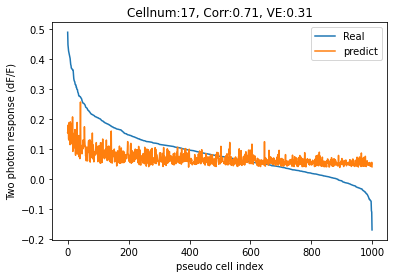

In [ ]:
# plt.figure(dpi=300) # specify resolution
plt.plot(v)
plt.plot(pred_yhat_paired)
corr=np.corrcoef(v,pred_yhat_paired)[0,1]
VE=GF.get_VE(pred=pred_yhat_paired, real=v)
plt.title(f'Cellnum:{cell_num}, Corr:{round(corr,2)}, VE:{round(VE,2)}')
plt.xlabel('pseudo cell index')
plt.ylabel('Two photon response (dF/F)')
plt.legend(['Real','predict'])

Text(0, 0.5, 'Simulated neuronal response')

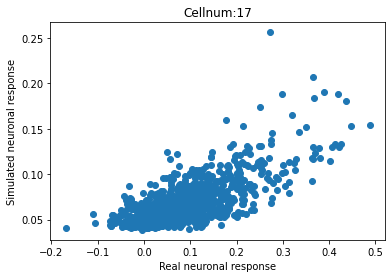

In [ ]:
# plt.figure(dpi=300)
x=v
y=pred_yhat_paired
plt.scatter(x,y)
plt.title(f'Cellnum:{cell_num}')
plt.xlabel('Real neuronal response')
plt.ylabel('Simulated neuronal response')

# **For part 2** and other part: We offer you a visualization method to characterize the complex Receptive fields of V1 neurons. Visualization is trying to synthesize an image that can stimulate a neuron the most. 


folder existed
visualization response in model: 1.5872316


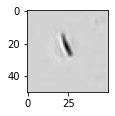

In [ ]:
vis_main_savepath=GF.mkdir(main_savepath,'visualization_imgs') # define the visualization images save path. 

vis_savepath=f"{vis_main_savepath}/cell{cell_num}.jpg"
# ——————————————————————————————————
# ↓ line below will automatically save the visualization image array as an image.
# if the visualization image exists in the defined foler, it will not run the 
# visualization process, instead, it will load the image as an array. 
# If you want to run the algorithm many times, you need to delete the visualization 
# in the folder, or you can simply annotate the code below.  
if os.path.exists(vis_savepath):
  vis_img=GF.norm_to_1(np.array(PIL.Image.open(vis_savepath)))
else:
  t.tic()
  vis_img=GF.norm_to_1(visualize_neuron_single(cell_num, input_size, net)) # Visulization algorithm, 17.292371 seconds. for one vis. 
  t.toc()
  imsave(vis_savepath,vis_img)
# ——————————————————————————————————
plt.figure(figsize=(1.5,1.5))
plt.imshow(vis_img,cmap='gray')
print('visualization response in model:', net(torch.tensor(vis_img.reshape(1,1,50,50)).to(device)).detach().cpu().numpy().flatten()[cell_num])

#### Get top images


(1000, 1, 50, 50)


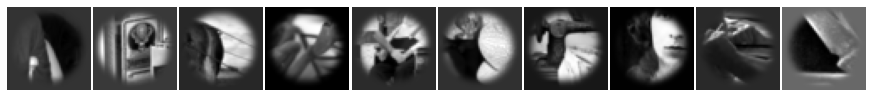

In [ ]:

topnum=10 # choose the top number 
rsp_1cell=real_response[:,cell_num] # get specific cell's response
toprsp,topindex=GF.sortTC(rsp_1cell) # sort the response from largest to smallest
topimgs=GF.norm_to_1(real_rsp_pair_pics[topindex]) #get imgs after sorting the response from largest to smallest
print(topimgs.shape)
top10imgs=topimgs[:topnum,0,:,:] # get top images, change the variable name to the top number
imshowtools.imshow(*top10imgs,padding=0.3,size=(12,12),rows=1,columns=10) # you can play with the parameters to get the best image showing.

####Get image weighted sum


Weighted sum response in model: 0.17704411


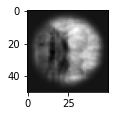

In [ ]:
top10rsp=np.reshape(toprsp[:topnum],(topnum,1,1)) # reshape, so you do not need to use for loop to do the weighted-sum
ws=np.mean(top10imgs*top10rsp,axis=0) 
plt.figure(figsize=(1.5,1.5))
plt.imshow(ws,cmap='gray')
ws_rsp=net(torch.tensor(np.reshape(GF.norm_to_1(ws),(1,1,50,50)),dtype=torch.float).to(device)).cpu().detach().numpy().flatten()[cell_num]
print('Weighted sum response in model:',ws_rsp)

# **For part 2** and others: Neural tuning to pattern stimuli

In [ ]:
# load pattern stimuli and get pattern stimulus response

ps=np.load('./Data/pattern_stimuli.npy') 
num,H,W=ps.shape
Pattern_stim=np.reshape(ps,(num,1,H,W))
PS_rsp_savepath=f"{main_savepath}/pattern_stim_rsp.npy"
if os.path.exists(PS_rsp_savepath):
  ps_pred_rsp=np.load(PS_rsp_savepath)
else:
  ps_pred_rsp=GF.get_model_rsp(net,Pattern_stim,batch_size=512,device=device,norm_1=1) # shape (1000, 302)
  np.save(PS_rsp_savepath,ps_pred_rsp)
print(ps_pred_rsp.shape)
# Variable: ps_pred_rsp, is the model response to pattern stimuli sets.

(9500, 302)


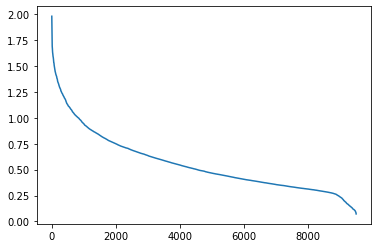

In [ ]:
# select a cell
rsp_to_ps_1cell=ps_pred_rsp[:,cell_num] # here, you can specify the cell number, 

# plot the tuning curve
value,index=GF.sortTC(rsp_to_ps_1cell)
plt.plot(value)

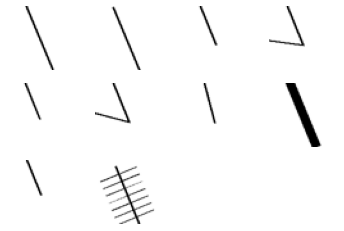

In [ ]:
# get top images
topnum=10
topPS=Pattern_stim[index[:topnum],0,:,:]
imshowtools.imshow(*topPS)


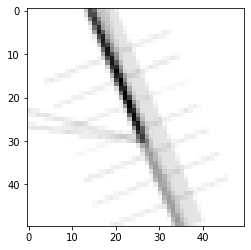

In [ ]:
# weighted sum
toprsp=(value[:topnum]).reshape((topnum,1,1))
WS=np.mean(np.multiply(topPS,toprsp),axis=0)
plt.imshow(WS,cmap='gray')

# **For Part 3**, Response map, sample, how V1 neuron model response to an image.


(325, 304)


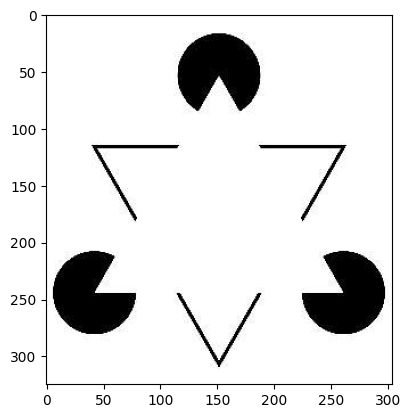

In [6]:
# image you selected should have width and height larger than 100.  
Image_path='./Data/kanizsa_triangle.jpg'
img0=PIL.Image.open(Image_path).convert('L')
img=np.array(img0)
H,W=img.shape
plt.imshow(img,cmap='gray')
print(img.shape)

In [7]:
# get block and img_subp_mat 
img_subp_mat,Number_of_blocks=GF.crop_img_subparts(img,crop_size=50,stride=1)
numofimgs,H,W=img_subp_mat.shape
img_subp_mat=img_subp_mat.reshape((numofimgs,1,H,W))
print('img_subp_mat shape:',img_subp_mat.shape)

Image shape (H,W): (325, 304)
Number of blocks: (276, 255)
img_subp_mat shape: (70380, 1, 50, 50)


In [10]:
# Get model response 
# you can save the all_rsp so that you do not need to run it again (be sure to change the name, or you will use the kanizsa_triangle image), which will cost a lot of time.
# If you want to use your own image, make sure to change the save name below!!!!
batch_size=512
all_rsp_savepath=f'{main_savepath}/kanizsa_triangle2.npy' # !! be sure to change this 
if os.path.exists(all_rsp_savepath):
  all_rsp=np.load(all_rsp_savepath)
else:
  all_rsp=GF.get_model_rsp(model=net,img_subp_mat=img_subp_mat,batch_size=batch_size,device=device,norm_1=1)
  np.save(all_rsp_savepath,all_rsp)


c:\Users\J\Desktop\TA_computational_perception\hw3\./functions\GS_functions.py:327: RuntimeWarning: invalid value encountered in divide
  mat_new[i, :, :] = (mat_new[i, :, :] - mat_new[i, :, :].min()) / (


0


c:\Users\J\Desktop\TA_computational_perception\hw3\./functions\GS_functions.py:246: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
c:\Users\J\Desktop\TA_computational_perception\hw3\./functions\GS_functions.py:246: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


KeyboardInterrupt: 

In [9]:
# Reshape model response to response map
all_rsp.shape
# plt.figure(dpi=200)
g=all_rsp[:,cell_num].reshape(Number_of_blocks)
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.subplot(122)
plt.imshow(g,cmap=None)
plt.colorbar() # this is trying to tell you the absolute response of the model.

ValueError: cannot reshape array of size 70104 into shape (276,255)

# **Your code start here**


In [ ]:
#  your code, please specify Part1 Part2
